# Importing Dataset

In [1]:
import os
import yaml
import torch.multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
# wandb config
import wandb
from dotenv import load_dotenv
load_dotenv()
from wandb.integration.ultralytics import add_wandb_callback
from ultralytics import YOLO
from collections import Counter

# Initialize your Weights & Biases environment
!yolo settings wandb=True



cwd = os.getcwd()
dataset_root_folder = os.path.join(cwd, "../../dataset")

# Funzione per generare i grafici delle perdite (Train e Validation Losses)
def plot_losses(data, figsize=(12, 10), title="Train and Validation Losses Over Epochs"):
    """
    Funzione per creare un plot delle perdite (Losses) di training e validazione su una griglia 2x2.

    Args:
        data (DataFrame): Un DataFrame contenente i dati da plottare.
        figsize (tuple): Dimensione della figura (larghezza, altezza).
        title (str): Titolo principale della figura.
    """
    # Configurazione dei grafici (fissa)
    plots = [
        (0, 0, 'Loss', 'blue', 'orange', 'Box Loss', 'train/box_loss', 'val/box_loss'),
        (0, 1, 'Loss', 'green', 'red', 'Class Loss', 'train/cls_loss', 'val/cls_loss'),
        (1, 0, 'Loss', 'purple', 'cyan', 'DFL Loss', 'train/dfl_loss', 'val/dfl_loss'),
        (1, 1, 'Score', 'magenta', 'brown', 'Validation Metrics', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)')
    ]

    # Configura la figura
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(title, fontsize=16)

    # Creazione dei grafici iterativamente
    for r, c, ylabel, color_train, color_val, plot_title, key_train, key_val in plots:
        ax = axes[r, c]
        ax.plot(data['epoch'], data[key_train], label=f'Train {plot_title}', color=color_train)
        ax.plot(data['epoch'], data[key_val], label=f'Val {plot_title}', color=color_val)
        ax.set_title(plot_title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(ylabel)
        ax.legend()
        ax.grid()

    # Layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_dataset(dataset_root):
    """
    Analyzes a YOLO dataset and plots the image distribution per split (train, valid, test)
    and the class distribution.

    Args:
        dataset_root (str): Path to the root of the YOLO dataset (should include 'train', 'valid', and 'test').
    """
    # Path to the YAML file
    yaml_path = os.path.join(dataset_root, "data.yaml")

    # Check if YAML file exists
    if not os.path.exists(yaml_path):
        raise FileNotFoundError(f"'data.yaml' file not found in {dataset_root}")

    # Read class names from the YAML file
    with open(yaml_path, 'r') as file:
        data_config = yaml.safe_load(file)
        class_names = data_config['names']

    # Subdirectories for train, valid, and test
    splits = ['train', 'valid', 'test']

    # Image distribution and class counts
    image_distribution = {}
    class_counts = Counter()

    for split in splits:
        images_dir = os.path.join(dataset_root, split, "images")
        labels_dir = os.path.join(dataset_root, split, "labels")

        # Count images
        if os.path.exists(images_dir):
            num_images = len([f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))])
            image_distribution[split] = num_images

        # Count classes
        if os.path.exists(labels_dir):
            for label_file in os.listdir(labels_dir):
                label_path = os.path.join(labels_dir, label_file)
                try:
                    with open(label_path, 'r') as file:
                        for line in file:
                            class_id = line.split()[0]
                            class_counts[class_id] += 1
                except PermissionError:
                    print(f"Permission denied for file: {label_path}")
                except Exception as e:
                    print(f"Error with file {label_path}: {e}")

    # Plot image distribution
    plt.figure(figsize=(10, 5))
    plt.bar(image_distribution.keys(), image_distribution.values(), color='skyblue')
    plt.title("Image Distribution per Split")
    plt.xlabel("Split")
    plt.ylabel("Number of Images")
    plt.show()

    # Plot class distribution
    plt.figure(figsize=(10, 5))
    class_ids = [int(cid) for cid in class_counts.keys()]
    frequencies = [class_counts[cid] for cid in class_counts.keys()]
    class_labels = [class_names[cid] for cid in class_ids]

    plt.bar(class_labels, frequencies, color='salmon')
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(matrix_path):
    matrix = plt.imread(matrix_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(matrix)
    plt.axis('off')
    plt.show()

C:\Users\siani\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: WARNING This integration is tested and supported for ultralytics v8.0.238 and below.
wandb: WARNING             Please report any issues to https://github.com/wandb/wandb/issues with the tag `yolov8`.


JSONDict("C:\Users\siani\AppData\Roaming\Ultralytics\settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "C:\\Users\\siani\\PycharmProjects\\AIxFootballAnalysis\\src\\training\\datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "4164f6bf860d8010f015d455e8afd5ad6b00d6918e89b195fad8e40aabf4e174",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": true,
  "vscode_msg": true
}
ðŸ’¡ Learn more about Ultralytics Settings at https://docs.ultralytics.com/quickstart/#ultralytics-settings


 # Determining best YOLO version

We'll evaluate three distinct version:

1. YOLO8L 
2. YOLO9c 
3. YOLO5L

**Dataset**

For this experiment we'll employ dataset's version 0. 
Such version is made of the **645** raw images, half of them taken from the publicly available dataset : https://universe.roboflow.com/project/football-players-detection-3zvbc/dataset/2 , while the other half was manually annotated

(such dataset is available at https://app.roboflow.com/emasengineeringworkspace/aixfootballanalysis/6)

Train val test split:
* Train = 510 images
* Val = 75 images
* Test = 60 images

## YOLO v8L

In [ ]:
#train yolo on GPU with 10 epochs
mp.freeze_support()  # Necessario su Windows
model = YOLO("yolov8l.pt")
model = model.cuda()
# print current path
dataset_path = os.path.join(dataset_root_folder, "yolov8", "v0")

PRO TIP  Replace 'model=yolov5l.pt' with new 'model=yolov5lu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|███████████████████████████████████████████████████████████████████████████████| 102M/102M [00:20<00:00, 5.17MB/s]


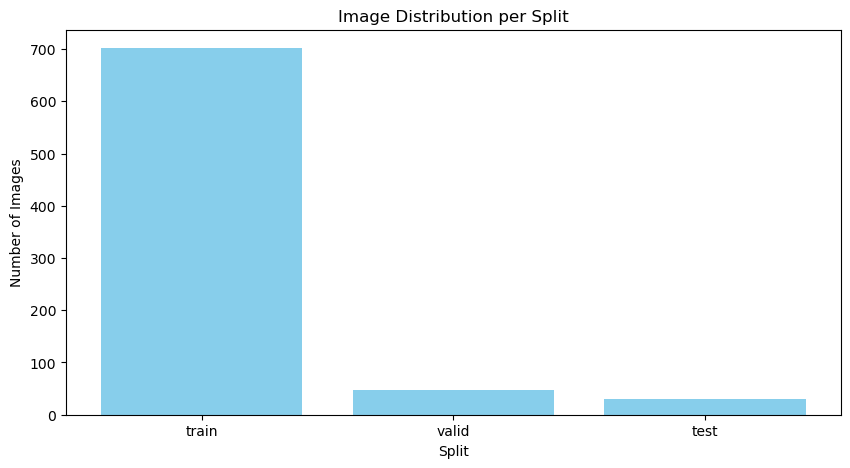

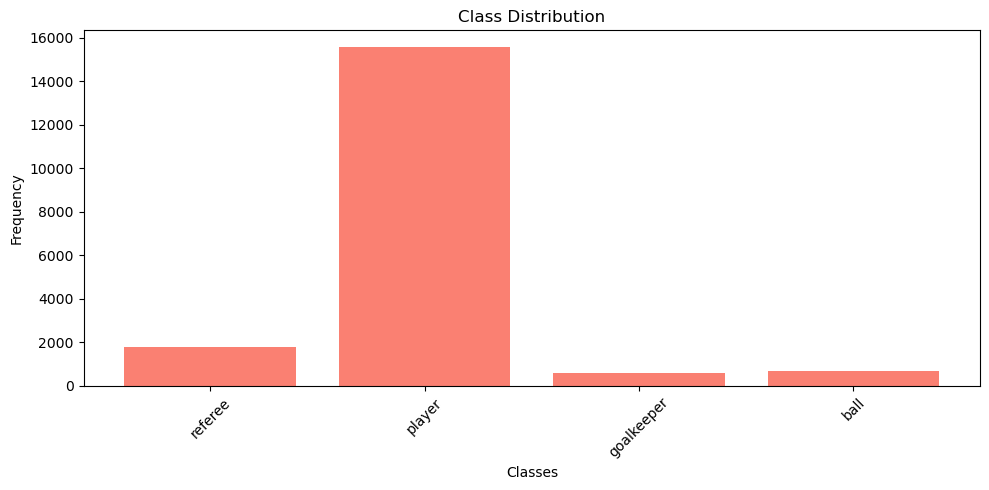

In [ ]:
# plot dataset
plot_dataset(dataset_path)

In [ ]:
model.train(data=os.path.join(dataset_path, "data.yaml"), epochs=50, imgsz=640, save=True, save_dir="yolov8", project="YOLO_version_train/v8L")

New https://pypi.org/project/ultralytics/8.3.74 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov5l.pt, data=c:\Users\siani\PycharmProjects\AIxFootballAnalysis\src\training\../../dataset\yolov5\v1\data.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=yolov5/v1, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

train: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov5\v1\train\labels.cache... 702 images, 0 backgrounds, 0 corrupt: 100%|██████████| 702/702 [00:00<?, ?it/s]
val: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov5\v1\valid\labels.cache... 47 images, 0 backgrounds, 0 corrupt: 100%|██████████| 47/47 [00:00<?, ?it/s]


Plotting labels to yolov5\v1\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolov5\v1\train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      10.9G      1.217      1.426       0.83        602        640: 100%|██████████| 44/44 [13:12<00:00, 18.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.85s/it]


                   all         47       1125      0.701      0.494      0.537      0.323

1 epochs completed in 0.227 hours.
Optimizer stripped from yolov5\v1\train\weights\last.pt, 106.8MB
Optimizer stripped from yolov5\v1\train\weights\best.pt, 106.8MB

Validating yolov5\v1\train\weights\best.pt...
Ultralytics 8.3.28  Python-3.10.0 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv5l summary (fused): 303 layers, 53,134,492 parameters, 0 gradients, 134.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


                   all         47       1125      0.702      0.494      0.539      0.323
                  ball         43         43          1          0      0.204     0.0557
            goalkeeper         32         32      0.716      0.472      0.584      0.357
                player         47        938      0.801      0.913      0.919      0.614
               referee         47        112       0.29      0.589      0.449      0.267
Speed: 0.2ms preprocess, 9.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to yolov5\v1\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000021BD8AD5A80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

In [ ]:
model.val(data=os.path.join(dataset_path, "data.yaml"), epochs=20, imgsz=640, save=True, save_dir="yolov8", project="YOLO_version_train/v8L")
model.test(data=os.path.join(dataset_path, "data.yaml"), imgsz=640, save=True, save_dir="yolov8", project="YOLO_version_train/v8L")

Ultralytics 8.3.28  Python-3.10.0 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv5l summary (fused): 303 layers, 53,134,492 parameters, 0 gradients, 134.7 GFLOPs


val: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov5\v1\valid\labels.cache... 47 images, 0 backgrounds, 0 corrupt: 100%|██████████| 47/47 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.42s/it]


                   all         47       1125      0.878      0.767      0.828       0.59
                  ball         43         43      0.906      0.326      0.501      0.222
            goalkeeper         32         32        0.8      0.875       0.89      0.683
                player         47        938      0.944      0.962      0.987      0.812
               referee         47        112      0.864      0.906      0.933      0.643
Speed: 2.4ms preprocess, 25.0ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to AIxFootballAnalysis\train5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002475F92E080>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

### Plots

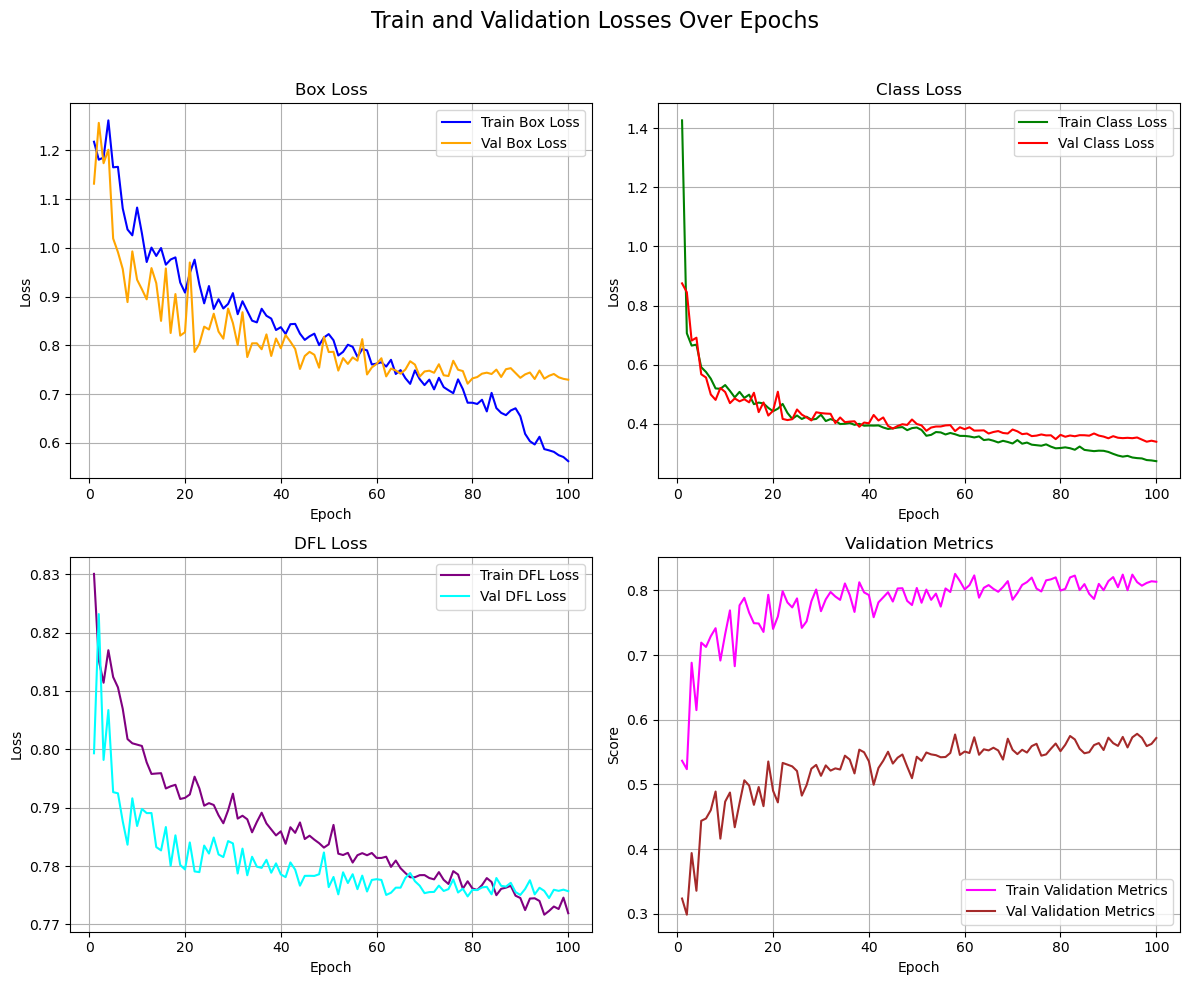

In [ ]:
results_path = os.path.join(cwd, "runs", "detect", "yolo5_dataset_v1", "results.csv")
data = pd.read_csv(results_path)
data
plot_losses(data)

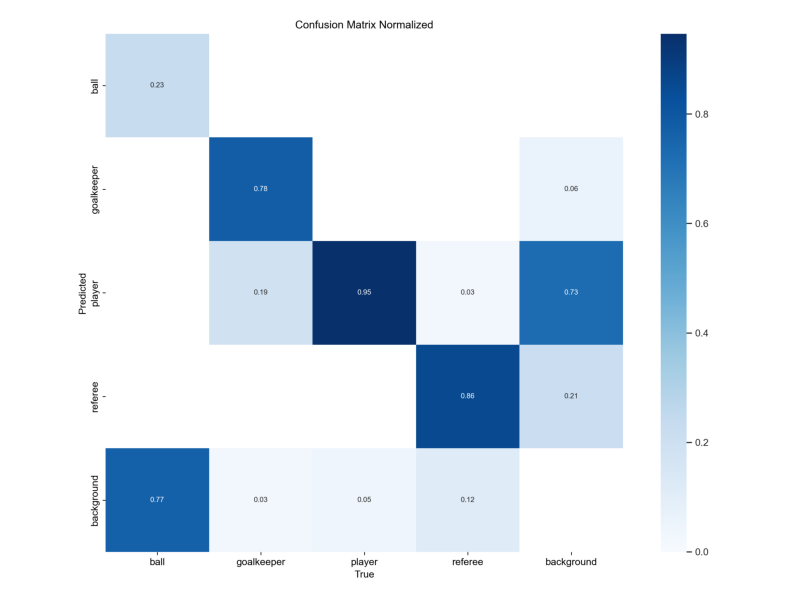

In [ ]:
# load and show confusion matrix
matrix_path = os.path.join(cwd, "runs", "detect", "yolo5_dataset_v1", "confusion_matrix_normalized.png")
plot_confusion_matrix(matrix_path)


PUT HERE NEXT YOLO TRAIN

## v2
Version 2 is made of the **312** raw images taken from the publicly available dataset : https://universe.roboflow.com/project/football-players-detection-3zvbc/dataset/2 (v2) **+ 76 new images** to which data augmentation was applied with the following criteria
* Outputs per training example: 2
* Flip: Horizontal
* Saturation: Between -25% and +25%
* Brightness: Between -20% and +20%

(such dataset is available at https://universe.roboflow.com/emasengineeringworkspace/aixfootballanalysis/dataset/3)

Train val test split:
* Train = 628 images
* Val = 37 images
* Test = 37 images

PRO TIP  Replace 'model=yolov5l.pt' with new 'model=yolov5lu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



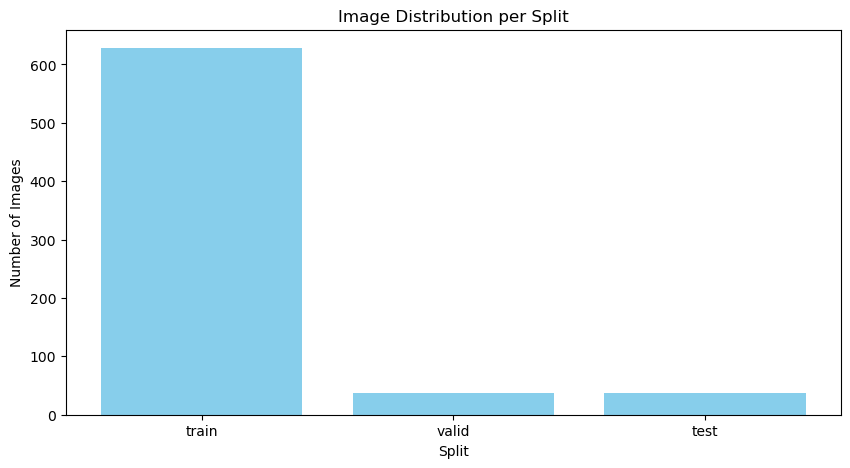

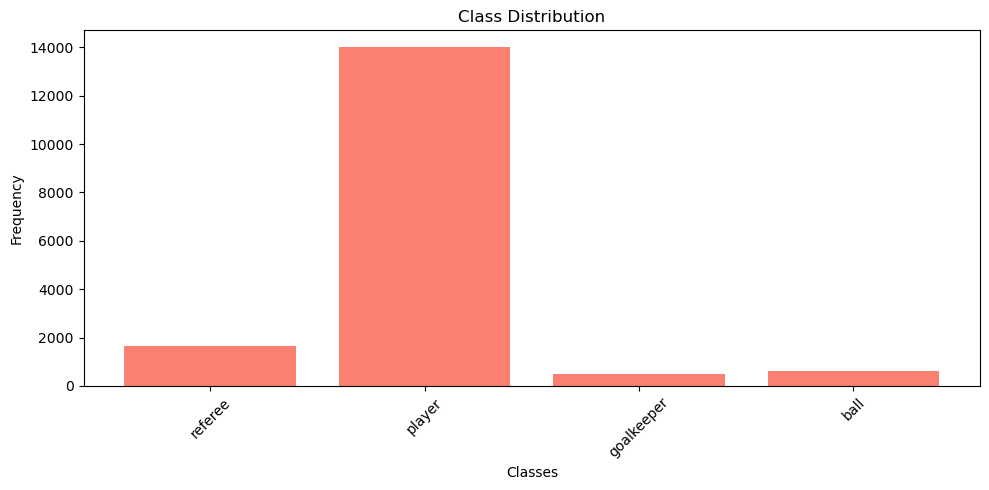

In [ ]:
#train yolo on GPU with 10 epochs
mp.freeze_support()  # Necessario su Windows
model = YOLO("yolov5l.pt")
model = model.cuda()
dataset_path = os.path.join(dataset_root_folder, "yolov5", "v2")
plot_dataset(dataset_path)

In [ ]:
# check if the model is on the GPU
model.train(data=os.path.join(dataset_path, "data.yaml"), epochs=100, imgsz=640, save=True, save_dir="yolov5")
model.val(data=os.path.join(dataset_path, "data.yaml"), epochs=20, imgsz=640, save=True, project="AIxFootballAnalysis")

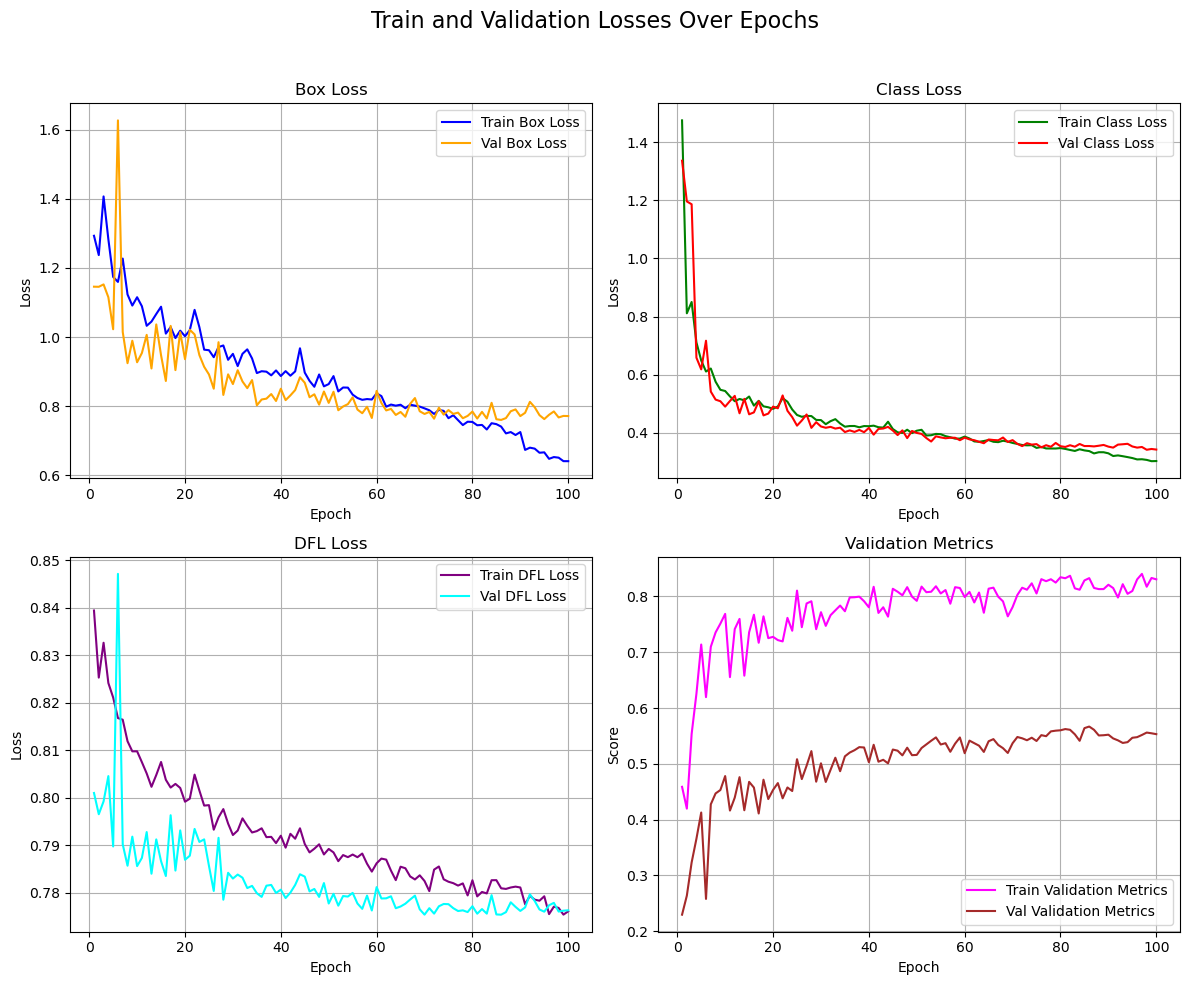

In [ ]:
### Plots
results_path = os.path.join(cwd, "runs", "detect", "yolo5_dataset_v2", "results.csv")
data = pd.read_csv(results_path)
data
plot_losses(data)

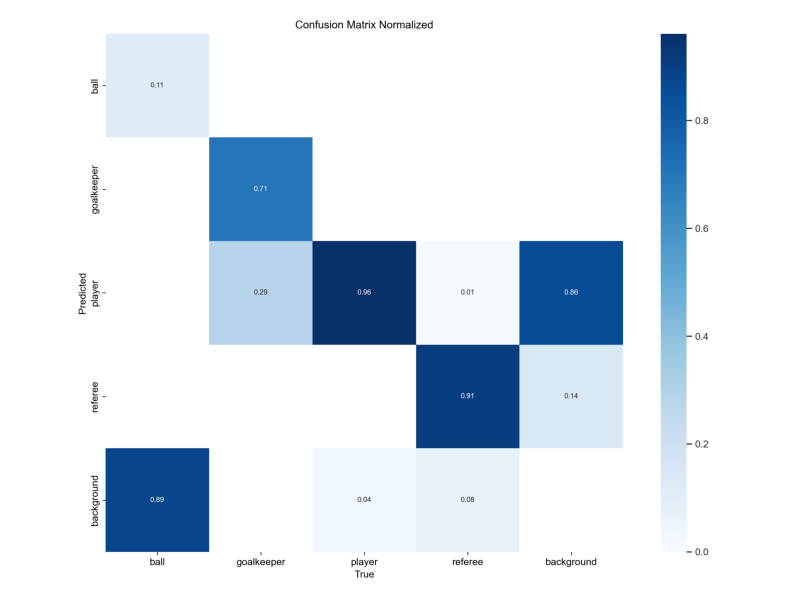

In [ ]:
matrix_path = os.path.join(cwd, "runs", "detect", "yolo5_dataset_v2", "confusion_matrix_normalized.png")
plot_confusion_matrix(matrix_path)

## v3
Version 2 is made of the **312** raw images taken from the publicly available dataset : https://universe.roboflow.com/project/football-players-detection-3zvbc/dataset/2 (v2) **+ 188 new images** to which data augmentation was applied with the following criteria
* Outputs per training example: 3
* Flip: Horizontal
* Saturation: Between -25% and +25%
* Brightness: Between -20% and +20%

(such dataset is available at https://universe.roboflow.com/emasengineeringworkspace/aixfootballanalysis/dataset/4)

Train val test split:
* Train = 1215 images
* Val = 55 images
* Test = 40 images

In [ ]:
#train yolo on GPU with 10 epochs
mp.freeze_support()  # Necessario su Windows
model = YOLO("yolov5l.pt")
model = model.cuda()
dataset_path = os.path.join(dataset_root_folder, "yolov5", "v3")

PRO TIP  Replace 'model=yolov5l.pt' with new 'model=yolov5lu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



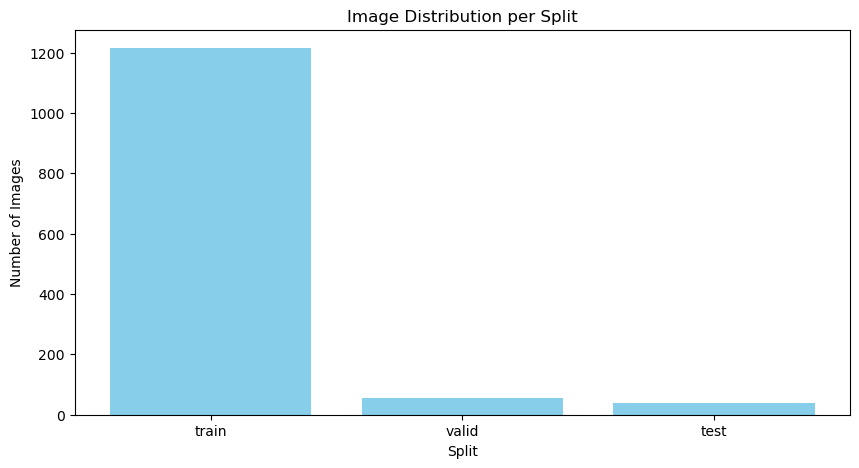

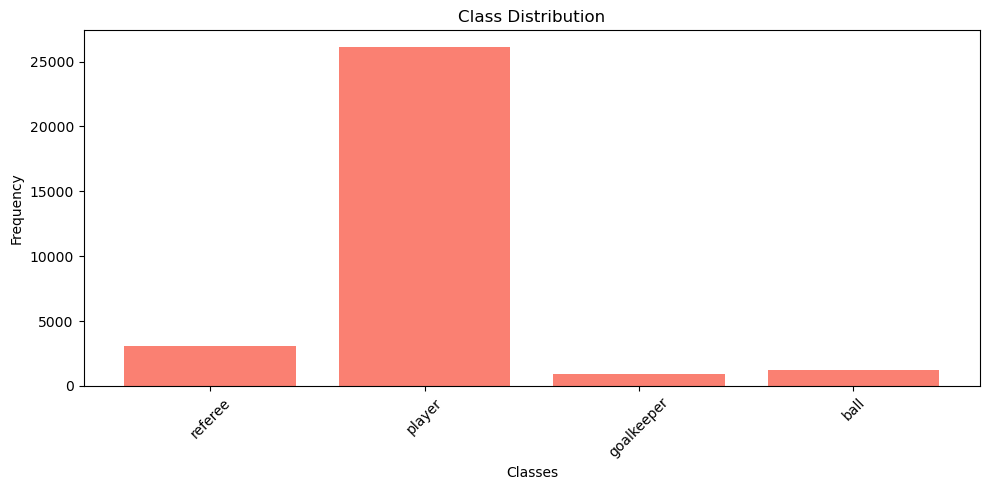

In [ ]:
# plot dataset
plot_dataset(dataset_path)

In [ ]:
# check if the model is on the GPU
model.train(data=os.path.join(dataset_path, "data.yaml"), epochs=100, imgsz=640, save=True, save_dir="yolov5")
model.val(data=os.path.join(dataset_path, "data.yaml"), epochs=20, imgsz=640, save=True, project="AIxFootballAnalysis")

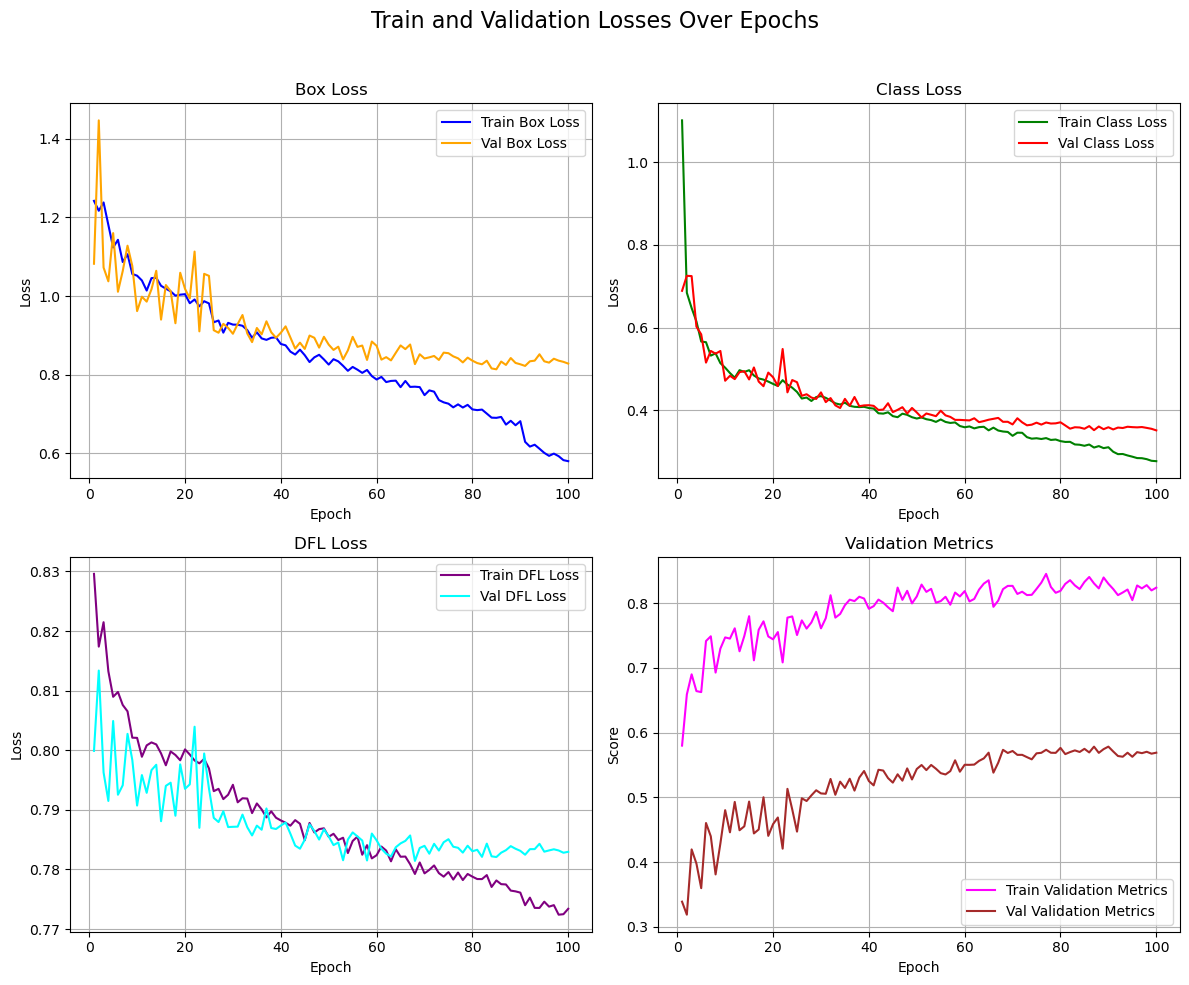

In [ ]:
### Plots
results_path = os.path.join(cwd, "runs", "detect", "yolo5_dataset_v3", "results.csv")
data = pd.read_csv(results_path)
data
plot_losses(data)

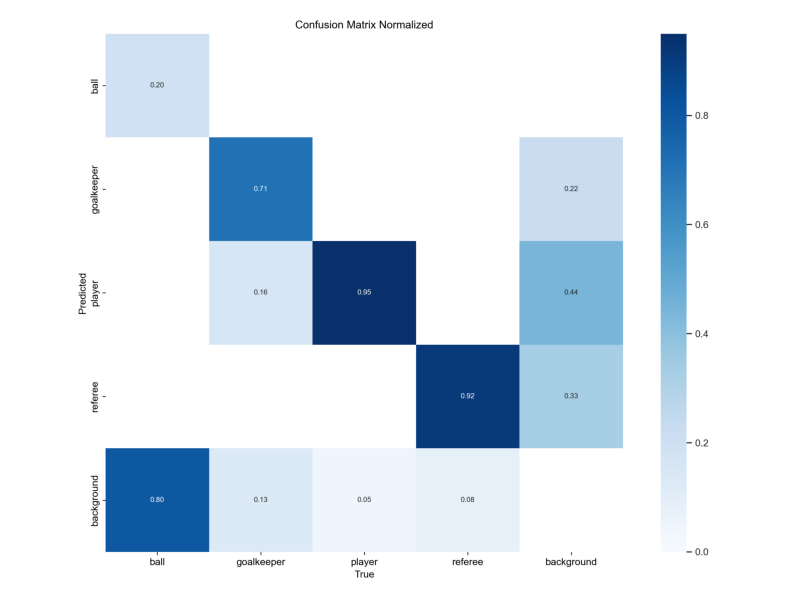

In [ ]:
# plot confusion matrix
matrix_path = os.path.join(cwd, "runs", "detect", "yolo5_dataset_v3", "confusion_matrix_normalized.png")
plot_confusion_matrix(matrix_path)

# YOLOv8

## v2
Version 2 is made of the **312** raw images taken from the publicly available dataset : https://universe.roboflow.com/project/football-players-detection-3zvbc/dataset/2 (v2) **+ 76 new images** to which data augmentation was applied with the following criteria
* Outputs per training example: 2
* Flip: Horizontal
* Saturation: Between -25% and +25%
* Brightness: Between -20% and +20%

(such dataset is available at https://universe.roboflow.com/emasengineeringworkspace/aixfootballanalysis/dataset/3)

Train val test split:
* Train = 628 images
* Val = 37 images
* Test = 37 images

In [ ]:
#train yolo on GPU with 10 epochs
mp.freeze_support()  # Necessario su Windows
model = YOLO("yolov8m.pt")
model = model.cuda()
# check if the model is on the GPU
dataset_path = os.path.join(dataset_root_folder, "yolov8", "v2")
model.train(data=dataset_path, epochs=10, imgsz=640, save=True)
model.val(data=dataset_path, epochs=10, imgsz=640, save=True, project="AIxFootballAnalysis")

New https://pypi.org/project/ultralytics/8.3.56 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov9c.pt, data=C:\Users\siani\PycharmProjects\AIxFootballAnalysis\src\training\../../dataset\yolov9\v1, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fal

RuntimeError: Dataset 'C://Users/siani/PycharmProjects/AIxFootballAnalysis/src/training/../../dataset/yolov9/v1' error  'C:\Users\siani\PycharmProjects\AIxFootballAnalysis\src\training\../../dataset\yolov9\v1' does not exist

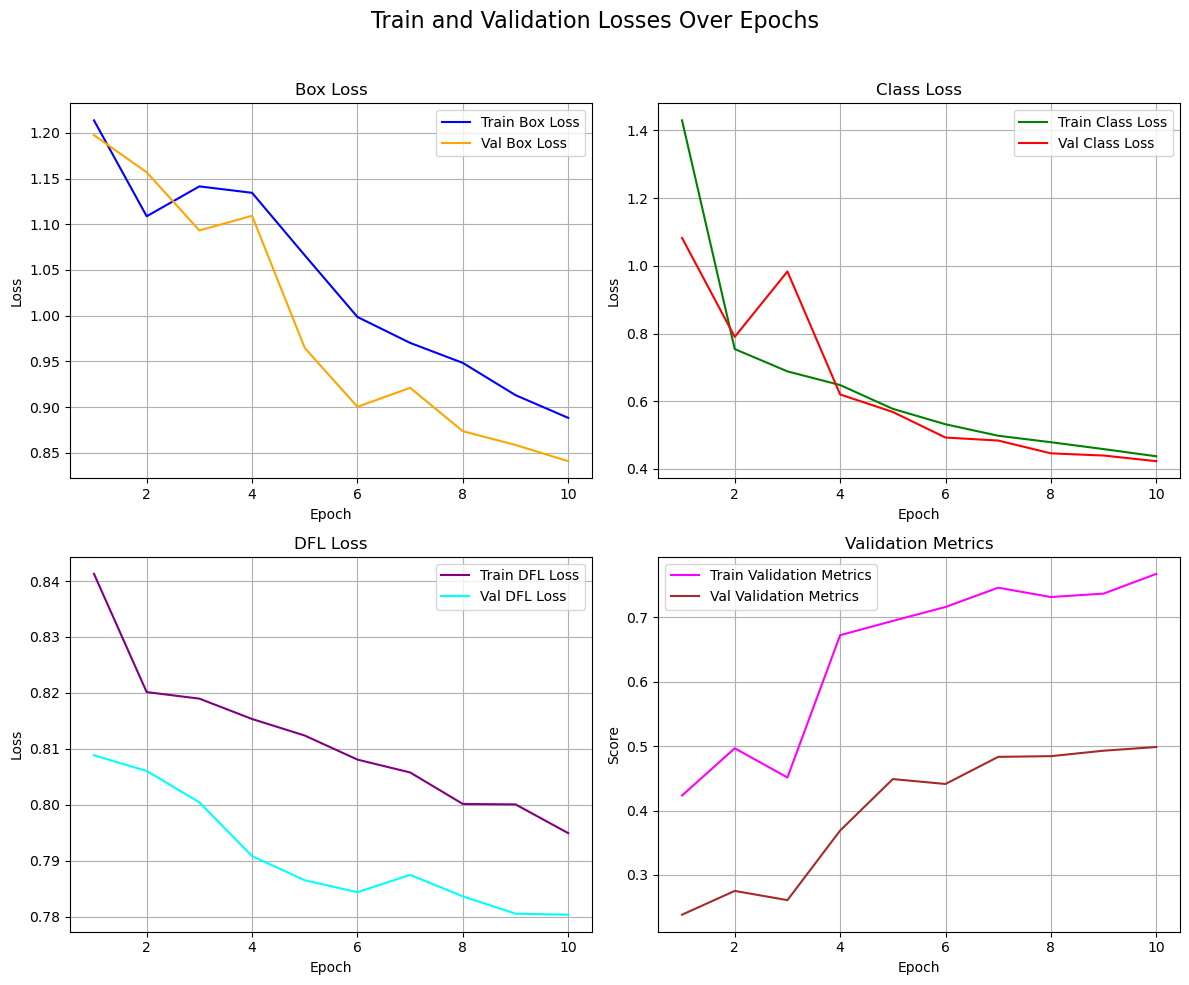

In [ ]:
### Plots
results_path = os.path.join(cwd, "runs", "detect", "yolo8m_dataset_v2", "results.csv")
data = pd.read_csv(results_path)
plot_losses(data)

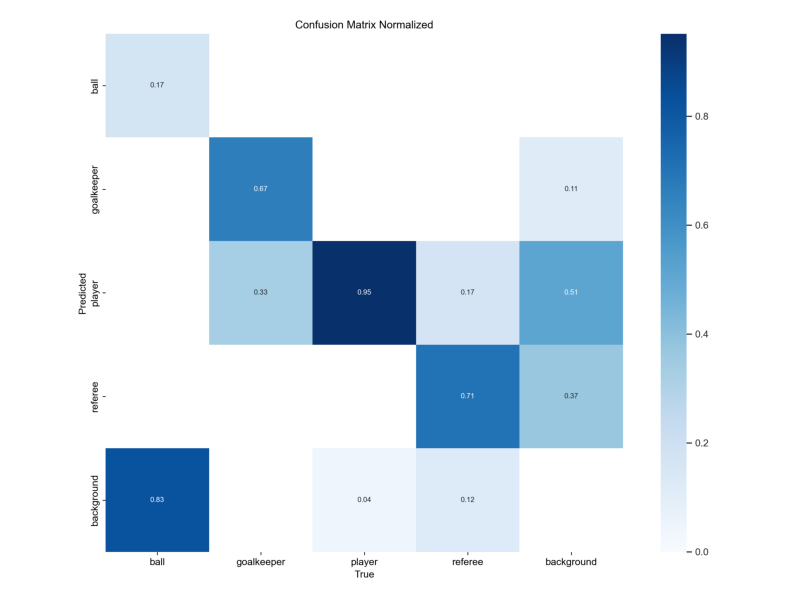

In [ ]:
# plot confusion matrix
matrix_path = os.path.join(cwd, "runs", "detect", "yolo8m_dataset_v2", "confusion_matrix_normalized.png")
plot_confusion_matrix(matrix_path)

## v2
Version 2 is made of the **312** raw images taken from the publicly available dataset : https://universe.roboflow.com/project/football-players-detection-3zvbc/dataset/2 (v2) **+ 76 new images** to which data augmentation was applied with the following criteria
* Outputs per training example: 2
* Flip: Horizontal
* Saturation: Between -25% and +25%
* Brightness: Between -20% and +20%

(such dataset is available at https://universe.roboflow.com/emasengineeringworkspace/aixfootballanalysis/dataset/3)

Train val test split:
* Train = 628 images
* Val = 37 images
* Test = 37 images


In [ ]:
#train yolo on GPU with 10 epochs
mp.freeze_support()  # Necessario su Windows
model = YOLO("yolov8l")
model = model.cuda()
# check if the model is on the GPU
dataset_path = os.path.join(dataset_root_folder, "yolov8", "v2")
model.train(data=os.path.join(dataset_path, "data.yaml"), epochs=10, imgsz=640, save=True)
model.val(data=os.path.join(dataset_path, "data.yaml"), epochs=10, imgsz=640, save=True, project="AIxFootballAnalysis")

100%|██████████| 83.7M/83.7M [00:07<00:00, 12.5MB/s]


New https://pypi.org/project/ultralytics/8.3.57 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov8l.pt, data=C:\Users\siani\PycharmProjects\AIxFootballAnalysis\src\training\../../dataset\yolov8\v2\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train15, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, s

train: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v2\train\labels.cache... 628 images, 0 backgrounds, 0 corrupt: 100%|██████████| 628/628 [00:00<?, ?it/s]
val: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v2\valid\labels.cache... 37 images, 0 backgrounds, 0 corrupt: 100%|██████████| 37/37 [00:00<?, ?it/s]


Plotting labels to runs\detect\train15\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train15
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      10.2G       1.24      1.823     0.8385         89        640: 100%|██████████| 40/40 [24:27<00:00, 36.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.13s/it]

                   all         37        890      0.347      0.251       0.22      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      10.2G      1.143     0.8064     0.8235         91        640: 100%|██████████| 40/40 [21:59<00:00, 32.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.30s/it]

                   all         37        890      0.681       0.51       0.53      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      10.3G      1.147     0.6849     0.8221         93        640: 100%|██████████| 40/40 [21:38<00:00, 32.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.15s/it]

                   all         37        890      0.516      0.184      0.143     0.0798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      10.2G      1.133      0.662     0.8168         92        640: 100%|██████████| 40/40 [23:43<00:00, 35.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.06s/it]

                   all         37        890      0.615      0.448      0.453      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      10.3G      1.077     0.5858      0.814         96        640: 100%|██████████| 40/40 [20:42<00:00, 31.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.07s/it]

                   all         37        890      0.735      0.616      0.639       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      10.3G      1.034      0.542     0.8113         95        640: 100%|██████████| 40/40 [24:11<00:00, 36.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.96s/it]

                   all         37        890       0.75      0.656      0.688      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      10.3G     0.9754     0.4993     0.8059         95        640: 100%|██████████| 40/40 [20:37<00:00, 30.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.26s/it]

                   all         37        890      0.746      0.656      0.713      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      10.3G     0.9605     0.4873     0.8015         94        640: 100%|██████████| 40/40 [20:21<00:00, 30.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.69s/it]

                   all         37        890      0.788        0.7      0.731      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      10.2G     0.9147     0.4591     0.8015         87        640: 100%|██████████| 40/40 [21:56<00:00, 32.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.78s/it]

                   all         37        890      0.806      0.651      0.733      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      10.2G     0.8922     0.4406     0.7964         92        640: 100%|██████████| 40/40 [19:55<00:00, 29.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.73s/it]

                   all         37        890      0.812      0.698      0.739      0.497



10 epochs completed in 3.724 hours.
Optimizer stripped from runs\detect\train15\weights\last.pt, 87.6MB
Optimizer stripped from runs\detect\train15\weights\best.pt, 87.6MB

Validating runs\detect\train15\weights\best.pt...
Ultralytics 8.3.28  Python-3.10.0 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 268 layers, 43,609,692 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.97s/it]


                   all         37        890      0.811      0.698      0.739        0.5
                  ball         35         35       0.82      0.171      0.246     0.0759
            goalkeeper         24         24      0.685      0.726      0.783      0.551
                player         37        742      0.932      0.962      0.984      0.761
               referee         37         89      0.808      0.933      0.941      0.612
Speed: 1.8ms preprocess, 136.7ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train15
Ultralytics 8.3.28  Python-3.10.0 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 268 layers, 43,609,692 parameters, 0 gradients, 164.8 GFLOPs


val: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v2\valid\labels.cache... 37 images, 0 backgrounds, 0 corrupt: 100%|██████████| 37/37 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.06s/it]


                   all         37        890      0.813        0.7      0.741      0.504
                  ball         35         35      0.819      0.171      0.253     0.0731
            goalkeeper         24         24      0.685      0.725      0.783      0.549
                player         37        742      0.929      0.961      0.981      0.773
               referee         37         89      0.818      0.944      0.947      0.621
Speed: 2.1ms preprocess, 104.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to AIxFootballAnalysis\train15


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001E65507BF40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

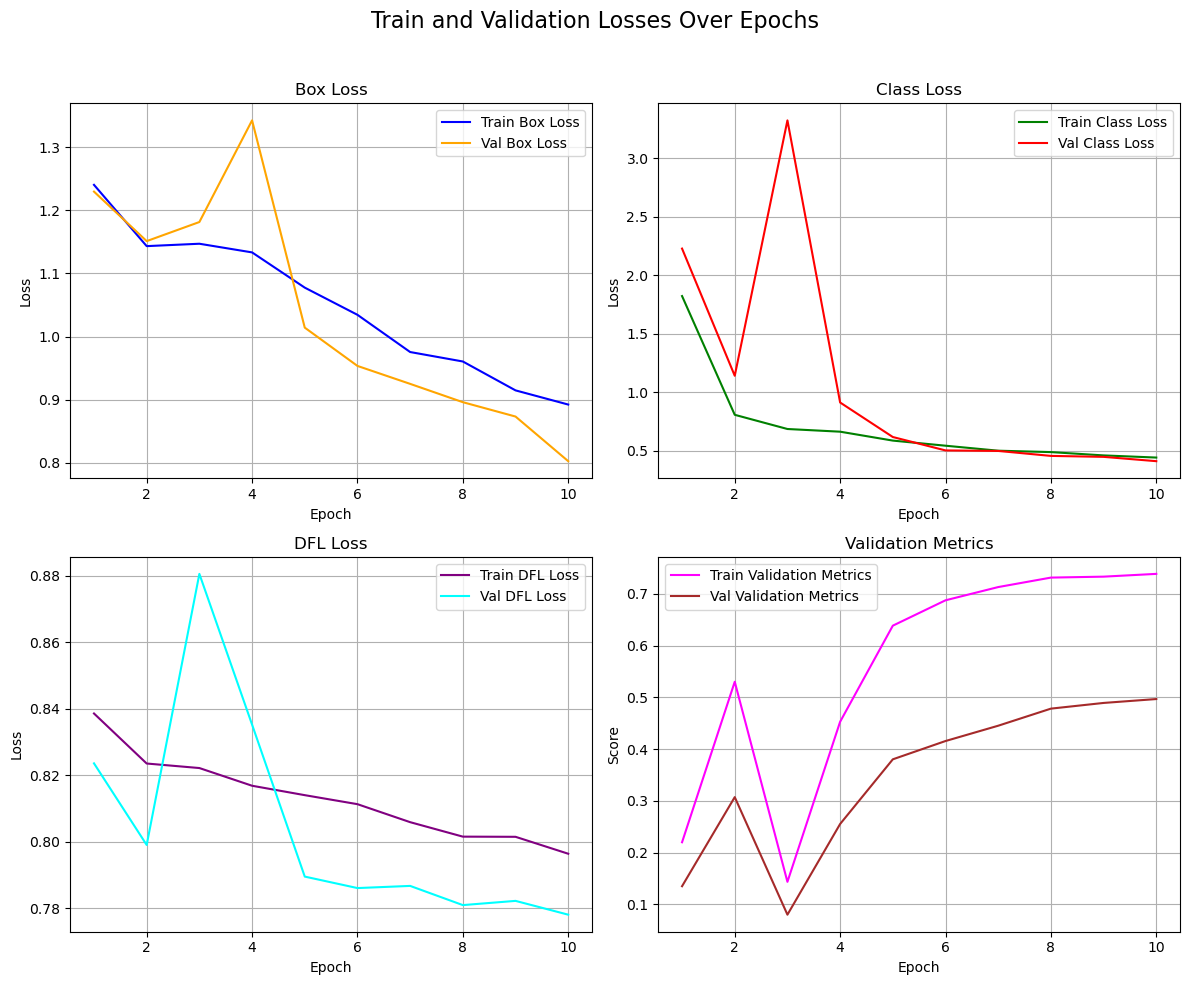

In [ ]:
### Plots
results_path = os.path.join(cwd, "runs", "detect", "yolo8l_dataset_v2", "results.csv")
data = pd.read_csv(results_path)
plot_losses(data)

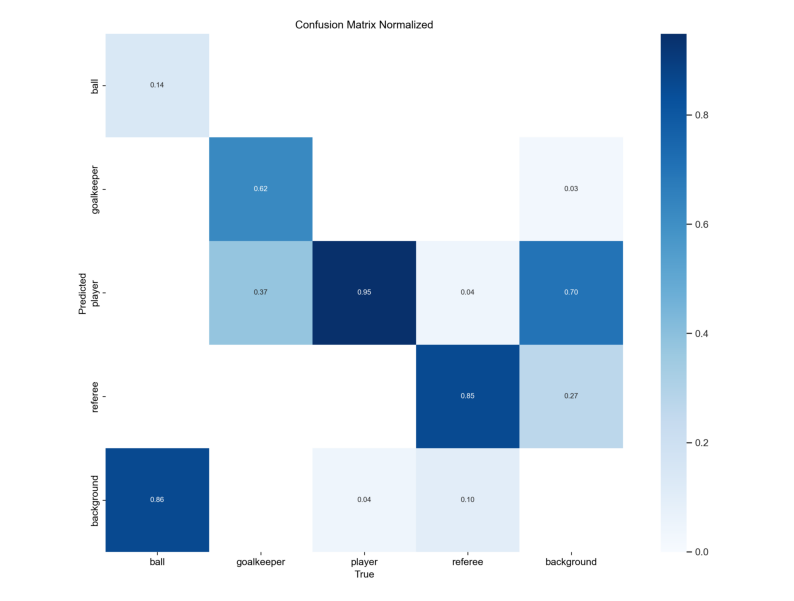

In [ ]:
# plot confusion matrix
matrix_path = os.path.join(cwd, "runs", "detect", "yolo8l_dataset_v2", "confusion_matrix_normalized.png")
plot_confusion_matrix(matrix_path)

## v3
Version 2 is made of the **312** raw images taken from the publicly available dataset : https://universe.roboflow.com/project/football-players-detection-3zvbc/dataset/2 (v2) **+ 188 new images** to which data augmentation was applied with the following criteria
* Outputs per training example: 3
* Flip: Horizontal
* Saturation: Between -25% and +25%
* Brightness: Between -20% and +20%

(such dataset is available at https://universe.roboflow.com/emasengineeringworkspace/aixfootballanalysis/dataset/4)

Train val test split:
* Train = 1215 images
* Val = 55 images
* Test = 40 images

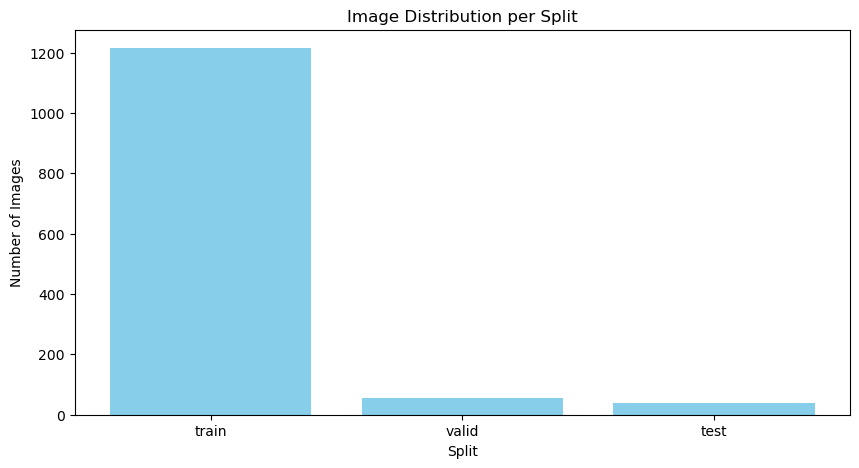

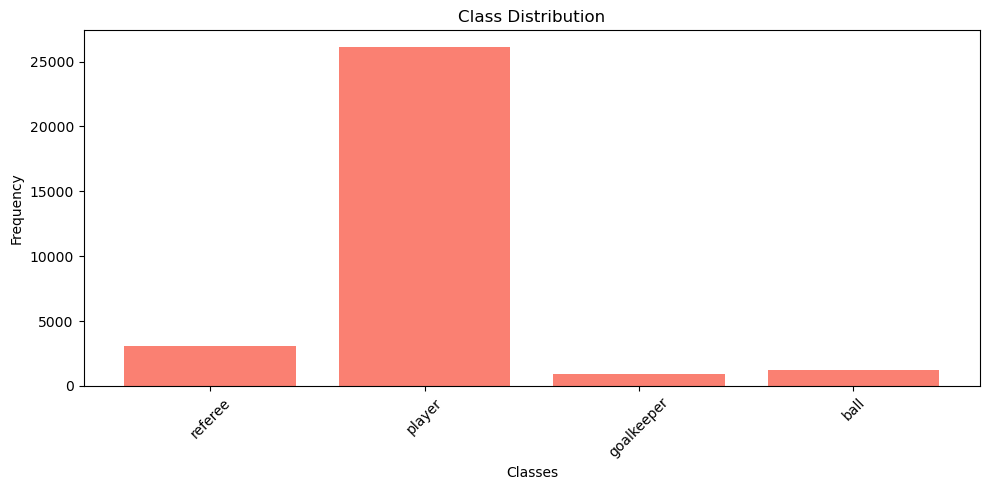

New https://pypi.org/project/ultralytics/8.3.75 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=c:\Users\siani\PycharmProjects\AIxFootballAnalysis\src\training\../../dataset\yolov8\v3\data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=yolov8/v3, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False

train: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3\train\labels... 1215 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1215/1215 [00:00<00:00, 1584.32it/s]


train: New cache created: C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3\train\labels.cache


val: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3\valid\labels... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<00:00, 985.99it/s]

val: New cache created: C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3\valid\labels.cache


Plotting labels to yolov8\v3\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolov8\v3\train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.32G      1.268      1.096     0.8327        434        640: 100%|██████████| 76/76 [06:24<00:00,  5.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]

                   all         55       1314      0.778      0.498      0.517      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.17G      1.206     0.6578     0.8142        485        640: 100%|██████████| 76/76 [07:52<00:00,  6.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]

                   all         55       1314      0.809      0.562      0.656      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.07G      1.258     0.6995     0.8166        685        640: 100%|██████████| 76/76 [07:26<00:00,  5.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.40s/it]

                   all         55       1314      0.689      0.586      0.568      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.12G      1.255     0.6801     0.8146        713        640: 100%|██████████| 76/76 [07:05<00:00,  5.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.52s/it]

                   all         55       1314      0.711      0.612      0.667      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.12G      1.147     0.5635     0.8081        505        640: 100%|██████████| 76/76 [04:58<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.71s/it]

                   all         55       1314      0.789      0.637      0.699      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.12G      1.155     0.5534     0.8079        550        640: 100%|██████████| 76/76 [09:01<00:00,  7.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         55       1314      0.842      0.619      0.731      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.14G      1.093     0.5284     0.8042        459        640: 100%|██████████| 76/76 [07:15<00:00,  5.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]

                   all         55       1314      0.812      0.679      0.755      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.14G      1.087     0.5119     0.8021        690        640: 100%|██████████| 76/76 [08:01<00:00,  6.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]

                   all         55       1314      0.812      0.598      0.691      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.03G      1.081     0.5094     0.7998        584        640: 100%|██████████| 76/76 [06:50<00:00,  5.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]

                   all         55       1314      0.862      0.695      0.749      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.13G      1.032     0.4862     0.7983        531        640: 100%|██████████| 76/76 [08:53<00:00,  7.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]

                   all         55       1314      0.786      0.705      0.741      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.12G      1.037      0.495     0.7966        726        640: 100%|██████████| 76/76 [06:03<00:00,  4.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.53s/it]

                   all         55       1314      0.755      0.681      0.734      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.12G     0.9915     0.4701     0.7959        681        640: 100%|██████████| 76/76 [08:30<00:00,  6.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]

                   all         55       1314      0.811      0.737      0.777       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.11G      1.033     0.4811     0.7972        670        640: 100%|██████████| 76/76 [07:43<00:00,  6.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]

                   all         55       1314       0.91      0.663      0.745      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.14G      1.017     0.4744     0.7962        629        640: 100%|██████████| 76/76 [07:43<00:00,  6.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.91s/it]

                   all         55       1314      0.817      0.709      0.765      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.12G     0.9991     0.4675     0.7946        634        640: 100%|██████████| 76/76 [08:26<00:00,  6.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]

                   all         55       1314      0.894      0.719       0.78      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.09G     0.9691     0.4501      0.791        500        640: 100%|██████████| 76/76 [05:07<00:00,  4.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]

                   all         55       1314      0.769      0.721      0.748      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.15G     0.9596     0.4515     0.7917        587        640: 100%|██████████| 76/76 [08:22<00:00,  6.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.38s/it]

                   all         55       1314      0.834      0.729      0.777        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.11G     0.9716     0.4519      0.794        479        640: 100%|██████████| 76/76 [07:59<00:00,  6.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.04s/it]

                   all         55       1314      0.864       0.71      0.775      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.13G     0.9866     0.4544     0.7936        467        640: 100%|██████████| 76/76 [08:24<00:00,  6.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]

                   all         55       1314      0.816      0.707      0.761      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.09G     0.9468     0.4378      0.792        515        640: 100%|██████████| 76/76 [07:49<00:00,  6.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.83s/it]

                   all         55       1314       0.82      0.728      0.775       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.11G     0.9297     0.4311     0.7917        523        640: 100%|██████████| 76/76 [07:09<00:00,  5.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]

                   all         55       1314       0.88       0.68      0.764      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.12G     0.9345     0.4356     0.7901        649        640: 100%|██████████| 76/76 [06:02<00:00,  4.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]

                   all         55       1314      0.818      0.727      0.804      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.11G     0.9207     0.4277     0.7901        684        640: 100%|██████████| 76/76 [06:27<00:00,  5.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]

                   all         55       1314       0.92       0.71      0.756      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.11G     0.9088     0.4251     0.7897        742        640: 100%|██████████| 76/76 [06:18<00:00,  4.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.35s/it]

                   all         55       1314       0.84      0.726      0.787      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.15G     0.9185     0.4255     0.7886        639        640: 100%|██████████| 76/76 [06:47<00:00,  5.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.49s/it]

                   all         55       1314      0.845      0.738      0.794      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.09G     0.9005     0.4154     0.7867        562        640: 100%|██████████| 76/76 [07:08<00:00,  5.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.03s/it]

                   all         55       1314      0.861      0.728      0.778      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.13G     0.8881     0.4104     0.7865        527        640: 100%|██████████| 76/76 [06:09<00:00,  4.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.17s/it]

                   all         55       1314      0.819      0.726      0.768      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         7G     0.8905     0.4145     0.7861        572        640: 100%|██████████| 76/76 [05:49<00:00,  4.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

                   all         55       1314      0.813      0.746      0.788      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.09G     0.8853     0.4095      0.786        580        640: 100%|██████████| 76/76 [05:12<00:00,  4.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.46s/it]

                   all         55       1314      0.864       0.72      0.774      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.08G     0.8771     0.4062     0.7862        636        640: 100%|██████████| 76/76 [05:42<00:00,  4.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]

                   all         55       1314      0.815      0.699      0.761      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.05G     0.8783     0.4031     0.7844        670        640: 100%|██████████| 76/76 [05:06<00:00,  4.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.53s/it]

                   all         55       1314      0.866       0.71      0.775      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.07G     0.8857      0.399     0.7848        550        640: 100%|██████████| 76/76 [05:23<00:00,  4.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]

                   all         55       1314      0.832       0.74      0.792      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       7.1G     0.8371     0.3839     0.7836        528        640: 100%|██████████| 76/76 [05:28<00:00,  4.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.67s/it]

                   all         55       1314      0.874      0.759      0.808      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.13G     0.8466     0.3892     0.7822        631        640: 100%|██████████| 76/76 [08:03<00:00,  6.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]

                   all         55       1314      0.793      0.732      0.781      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.12G     0.8451      0.388     0.7831        743        640: 100%|██████████| 76/76 [07:12<00:00,  5.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.53s/it]

                   all         55       1314      0.828       0.73      0.792      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.06G     0.8271     0.3802     0.7815        541        640: 100%|██████████| 76/76 [04:18<00:00,  3.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]

                   all         55       1314      0.829      0.734      0.789      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.13G     0.8237     0.3816     0.7809        679        640: 100%|██████████| 76/76 [06:55<00:00,  5.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.84s/it]

                   all         55       1314      0.896      0.752      0.811      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.08G     0.8138     0.3736     0.7813        664        640: 100%|██████████| 76/76 [04:24<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all         55       1314      0.882      0.751      0.803      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.12G     0.8164     0.3761     0.7797        669        640: 100%|██████████| 76/76 [05:07<00:00,  4.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.41s/it]

                   all         55       1314      0.859       0.75      0.788      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.04G     0.8043     0.3698     0.7794        561        640: 100%|██████████| 76/76 [06:45<00:00,  5.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]

                   all         55       1314      0.804      0.744      0.785      0.517


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       7.2G     0.7638     0.3645     0.7796        356        640: 100%|██████████| 76/76 [04:42<00:00,  3.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.59s/it]

                   all         55       1314      0.856      0.758      0.802      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.21G     0.7413     0.3536     0.7797        353        640: 100%|██████████| 76/76 [05:01<00:00,  3.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.88s/it]

                   all         55       1314      0.843      0.775      0.808      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.19G     0.7453     0.3521     0.7806        353        640: 100%|██████████| 76/76 [04:16<00:00,  3.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]

                   all         55       1314      0.865      0.741      0.806      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.19G     0.7395     0.3513      0.778        347        640: 100%|██████████| 76/76 [05:34<00:00,  4.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.24s/it]

                   all         55       1314      0.863      0.735      0.798      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       7.2G     0.7125     0.3386      0.777        354        640: 100%|██████████| 76/76 [09:23<00:00,  7.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]

                   all         55       1314      0.894      0.758      0.835      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.17G     0.7041     0.3359     0.7768        344        640: 100%|██████████| 76/76 [07:28<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.01s/it]

                   all         55       1314      0.862       0.75      0.807      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.17G     0.6921     0.3303      0.776        338        640: 100%|██████████| 76/76 [07:05<00:00,  5.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]

                   all         55       1314      0.862      0.756      0.807      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       7.2G     0.6878     0.3272     0.7761        333        640: 100%|██████████| 76/76 [06:49<00:00,  5.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.91s/it]

                   all         55       1314      0.854      0.772       0.81      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       7.2G     0.6716     0.3203     0.7759        352        640: 100%|██████████| 76/76 [06:56<00:00,  5.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]

                   all         55       1314      0.873      0.763      0.814       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       7.2G      0.664     0.3166     0.7765        353        640: 100%|██████████| 76/76 [03:57<00:00,  3.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.14s/it]

                   all         55       1314      0.878      0.761      0.822      0.541



50 epochs completed in 5.636 hours.
Optimizer stripped from yolov8\v3\train\weights\last.pt, 52.0MB
Optimizer stripped from yolov8\v3\train\weights\best.pt, 52.0MB

Validating yolov8\v3\train\weights\best.pt...
Ultralytics 8.3.28  Python-3.10.0 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.50s/it]


                   all         55       1314      0.894      0.758      0.835      0.557
                  ball         51         51      0.884        0.3      0.505      0.176
            goalkeeper         38         38      0.844      0.816      0.876      0.625
                player         55       1095      0.956      0.969      0.989      0.774
               referee         55        130      0.892      0.948      0.972      0.652
Speed: 0.2ms preprocess, 72.3ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to yolov8\v3\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000018B4D994FD0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

In [ ]:
#train yolo on GPU with 10 epochs
mp.freeze_support()  # Necessario su Windows
model = YOLO("yolov8m.pt")
model = model.cuda()
# check if the model is on the GPU
dataset_path = os.path.join(dataset_root_folder, "yolov8", "v3")
plot_dataset(dataset_path)

model.train(data=os.path.join(dataset_path, "data.yaml"), epochs=50, imgsz=640, save=True, project="yolov8/v3")

#model.val(data=os.path.join(dataset_path, "data.yaml"), epochs=20, imgsz=640, save=True, project="AIxFootballAnalysis")

## v3 with copy paste augmentation


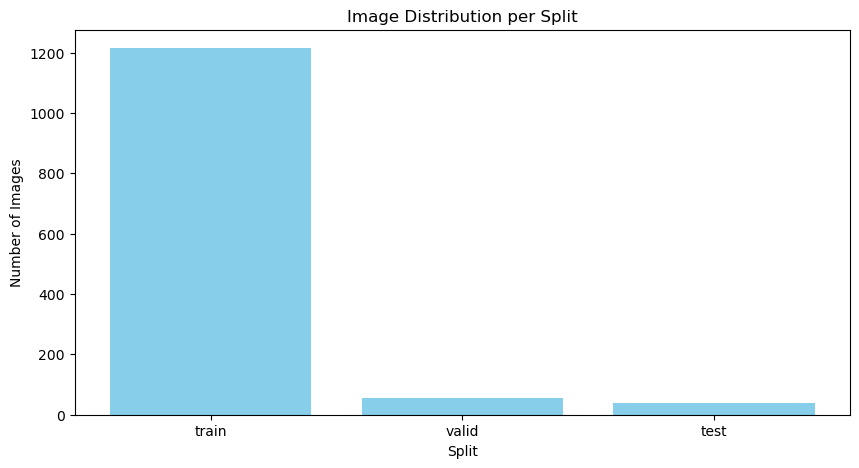

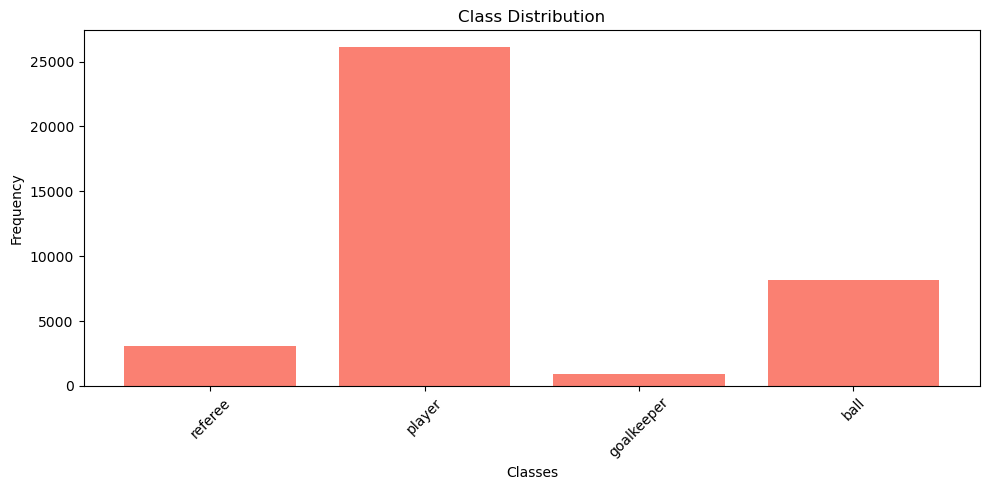

New https://pypi.org/project/ultralytics/8.3.75 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=c:\Users\siani\PycharmProjects\AIxFootballAnalysis\src\training\../../dataset\yolov8\v3_copy_paste_aug\data.yaml, epochs=2, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=yolov8_v3_copy_paste_aug, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None,

wandb: Currently logged in as: sianiemanuele (sianiemanuele_07) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed 


train: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3_copy_paste_aug\train\labels.cache... 1215 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1215/1215 [00:00<?, ?it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3_copy_paste_aug\train\labels.cache... 1215 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1215/1215 [00:00<?, ?it/s]
val: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3_copy_paste_aug\valid\labels.cache... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<?, ?it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3_copy_paste_aug\valid\labels.cache... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<?, ?it/s]


Plotting labels to yolov8_v3_copy_paste_aug\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolov8_v3_copy_paste_aug\train2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      7.64G       1.29       1.11     0.8331        590        640: 100%|██████████| 76/76 [05:24<00:00,  4.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.78s/it]


                   all         55       1314      0.655      0.558      0.594      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      7.47G       1.17     0.6298     0.8078        582        640: 100%|██████████| 76/76 [04:51<00:00,  3.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


                   all         55       1314      0.727      0.621      0.687      0.436

2 epochs completed in 0.178 hours.
Optimizer stripped from yolov8_v3_copy_paste_aug\train2\weights\last.pt, 52.0MB
Optimizer stripped from yolov8_v3_copy_paste_aug\train2\weights\best.pt, 52.0MB

Validating yolov8_v3_copy_paste_aug\train2\weights\best.pt...
Ultralytics 8.3.28  Python-3.10.0 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


                   all         55       1314      0.728      0.622      0.686      0.435
                  ball         51         51      0.543      0.098      0.141     0.0463
            goalkeeper         38         38      0.861      0.653      0.813      0.534
                player         55       1095      0.916      0.943      0.975      0.674
               referee         55        130       0.59      0.792      0.816      0.487
Speed: 0.6ms preprocess, 26.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to yolov8_v3_copy_paste_aug\train2


lr/pg0,▁█
lr/pg1,▁█
lr/pg2,▁█
metrics/mAP50(B),▁█
metrics/mAP50-95(B),▁█
metrics/precision(B),▁█
metrics/recall(B),▁█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▁


In [ ]:
#train yolo on GPU with 10 epochs
mp.freeze_support()  # Necessario su Windows
model = YOLO("yolov8m.pt")
model = model.cuda()
#add_wandb_callback(model, enable_model_checkpointing=True)
# check if the model is on the GPU
dataset_path = os.path.join(dataset_root_folder, "yolov8", "v3_copy_paste_aug")
plot_dataset(dataset_path)

model.train(data=os.path.join(dataset_path, "data.yaml"), epochs=2, imgsz=640, save=True, project="yolov8_v3_copy_paste_aug")

wandb.finish()

#model.val(data=os.path.join(dataset_path, "data.yaml"), epochs=20, imgsz=640, save=True, project="yolov8/v3_copy_paste_aug")

In [ ]:
import torch
import torch.nn as nn
import os
from ultralytics import YOLO

class CustomComputeLoss:
    def __init__(self, model):
        self.model = model
        self.iou_weight = 1.0  # Standard IoU weight
        self.obj_weight = 1.0  # Objectness weight
        self.cls_weight = 1.0  # Classification weight
        self.small_object_boost = 2.0  # Boost weight for small objects

    def __call__(self, preds, targets):
        """ Compute custom loss while prioritizing small objects """
        iou_loss, obj_loss, cls_loss = self.model.loss(preds, targets)

        # Get bounding box areas (width * height)
        bbox_areas = (targets[:, 3] - targets[:, 1]) * (targets[:, 4] - targets[:, 2])

        # Identify small objects (area < 0.01 of image size)
        small_objects = bbox_areas < 0.01

        # Boost IoU loss for small objects
        iou_loss[small_objects] *= self.small_object_boost

        # Compute total loss
        total_loss = (self.iou_weight * iou_loss +
                      self.obj_weight * obj_loss +
                      self.cls_weight * cls_loss)
        return total_loss

# Initialize YOLO model
model = YOLO("yolov8m.pt").cuda()
add_wandb_callback(model, enable_model_checkpointing=True, enable_train_validation_logging=True)


# Replace the default loss function with our custom loss
model.loss = CustomComputeLoss(model)

# Train YOLO with the modified loss
dataset_path = os.path.join(dataset_root_folder, "yolov8", "v3_copy_paste_aug")
# plot_dataset(dataset_path)

model.train(data=os.path.join(dataset_path, "data.yaml"), epochs=50, imgsz=640, save=True, project="yolov8/v3_copy_paste_aug_CUSTOM_LOSS")

New https://pypi.org/project/ultralytics/8.3.75 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=c:\Users\siani\PycharmProjects\AIxFootballAnalysis\src\training\../../dataset\yolov8\v3_copy_paste_aug\data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=yolov8/v3_copy_paste_aug_CUSTOM_LOSS, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False

train: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3_copy_paste_aug\train\labels.cache... 1215 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1215/1215 [00:00<?, ?it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3_copy_paste_aug\train\labels.cache... 1215 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1215/1215 [00:00<?, ?it/s]
val: Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3_copy_paste_aug\valid\labels.cache... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<?, ?it/s]Scanning C:\Users\siani\PycharmProjects\AIxFootballAnalysis\dataset\yolov8\v3_copy_paste_aug\valid\labels.cache... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<?, ?it/s]


Plotting labels to yolov8\v3_copy_paste_aug_CUSTOM_LOSS\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolov8\v3_copy_paste_aug_CUSTOM_LOSS\train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.49G       1.29       1.11     0.8331        590        640: 100%|██████████| 76/76 [10:39<00:00,  8.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.60s/it]


                   all         55       1314      0.655      0.558      0.594      0.362
YOLOv8m summary (fused): 218 layers, 25,886,080 parameters, 0 gradients, 78.9 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 23/23 [00:11<00:00,  2.04it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.36G      1.248      0.664     0.8135        582        640: 100%|██████████| 76/76 [05:59<00:00,  4.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.18s/it]


                   all         55       1314      0.718      0.622      0.673      0.365


Generating Visualizations for batch-1/1: 100%|██████████| 23/23 [00:11<00:00,  2.08it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.48G      1.226     0.6629     0.8149        804        640: 100%|██████████| 76/76 [07:32<00:00,  5.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.90s/it]


                   all         55       1314      0.722      0.639      0.673      0.383


Generating Visualizations for batch-1/1: 100%|██████████| 23/23 [00:10<00:00,  2.10it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.53G      1.247     0.6526     0.8116        764        640: 100%|██████████| 76/76 [09:39<00:00,  7.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


                   all         55       1314      0.728      0.628      0.669      0.395


Generating Visualizations for batch-1/1: 100%|██████████| 23/23 [00:10<00:00,  2.09it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.55G      1.193     0.5885     0.8086        659        640: 100%|██████████| 76/76 [07:49<00:00,  6.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.46s/it]


                   all         55       1314      0.793      0.636      0.705      0.451


Generating Visualizations for batch-1/1: 100%|██████████| 23/23 [00:10<00:00,  2.10it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.05G      1.133     0.5522     0.8019        640        640: 100%|██████████| 76/76 [08:35<00:00,  6.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


                   all         55       1314      0.726      0.696      0.705      0.457


Generating Visualizations for batch-1/1: 100%|██████████| 23/23 [00:10<00:00,  2.10it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.49G      1.143      0.547     0.8046        558        640: 100%|██████████| 76/76 [04:41<00:00,  3.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


                   all         55       1314      0.825      0.687      0.721      0.417


Generating Visualizations for batch-1/1: 100%|██████████| 23/23 [00:10<00:00,  2.11it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.56G      1.297     0.6129     0.8103        663        640:  55%|█████▌    | 42/76 [02:40<02:10,  3.83s/it]


KeyboardInterrupt: 